# **Random Forest**

## **Imports**

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score, 
                             precision_score, f1_score, classification_report)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, clear_output
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## **Parse TFR**

In [16]:
def parse_tfr(proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64),
    }
    rec = tf.io.parse_single_example(proto, feature_description)
    image = tf.image.decode_jpeg(rec['image'], channels=3)
    label = rec['label']
    return image, label

train_file = 'data/oversampled_train_images.tfrecords'
val_file = 'data/preprocessed_val_images.tfrecords'
test_file = 'data/preprocessed_test_images.tfrecords'

train_dataset = tf.data.TFRecordDataset(train_file)
train_dataset = train_dataset.map(parse_tfr)

val_dataset = tf.data.TFRecordDataset(val_file)
val_dataset = val_dataset.map(parse_tfr)

test_dataset = tf.data.TFRecordDataset(test_file)
test_dataset = test_dataset.map(parse_tfr)


In [17]:
num_train_examples = sum(1 for _ in train_dataset)
num_val_examples = sum(1 for _ in val_dataset)
num_test_examples = sum(1 for _ in test_dataset)

print(f">> Number of examples in the training dataset: {num_train_examples}")
print(f">> Number of examples in the validation dataset: {num_val_examples}")
print(f">> Number of examples in the test dataset: {num_test_examples}")

>> Number of examples in the training dataset: 4464
>> Number of examples in the validation dataset: 1280
>> Number of examples in the test dataset: 1


## **Helper Functions**

In [18]:
def evaluate_rf(classifier, X_train, y_train, X_val, y_val, class_names=None):
    y_train_pred = classifier.predict(X_train)
    y_val_pred = classifier.predict(X_val)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')

    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred, average='weighted')
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    
    overall_metrics_df = pd.DataFrame({
        "Metric": ["Accuracy", "Weighted Recall", "Weighted Precision", "Weighted F1 Score"],
        "Training": [train_accuracy, train_recall, train_precision, train_f1],
        "Validation": [val_accuracy, val_recall, val_precision, val_f1]
    })
    confusion_val = confusion_matrix(y_val, y_val_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_val, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Validation")
    plt.show()
    
    print("Overall Metrics:")
    print(overall_metrics_df)
    print("\n")

    print("Classification Report (Validation):")
    print(classification_report(y_val, y_val_pred, target_names=class_names))

    return overall_metrics_df


## **Random forest Model**

### **Prepare Data**

In [19]:
X_train, y_train = zip(*train_dataset)
X_val, y_val = zip(*val_dataset)
X_test, y_test = zip(*test_dataset)

# Flatten and scale the images
X_train = [tf.reshape(image, (-1,)).numpy() for image in X_train]
X_val = [tf.reshape(image, (-1,)).numpy() for image in X_val]
X_test = [tf.reshape(image, (-1,)).numpy() for image in X_test]

### **Train Random Forest**

In [20]:
rf_classifier = RandomForestClassifier(n_estimators=80, max_depth=20, max_leaf_nodes=50, min_samples_leaf=5, random_state=42)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, max_leaf_nodes=50, min_samples_leaf=5,
                       n_estimators=80, random_state=42)

## **Validation**

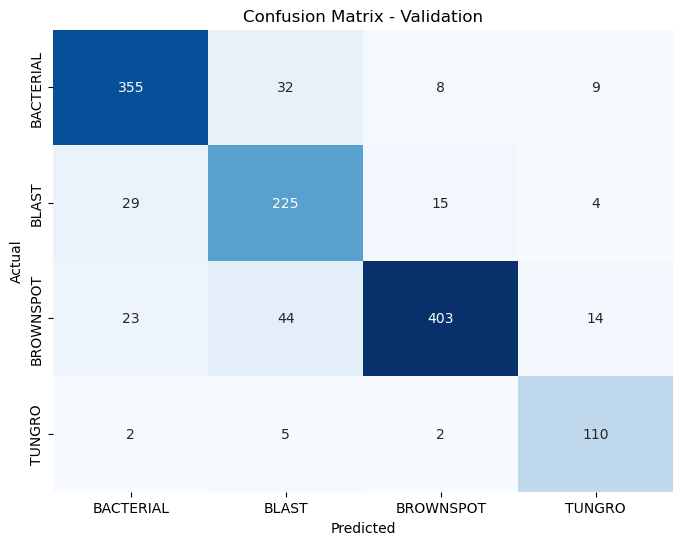

Overall Metrics:
               Metric  Training  Validation
0            Accuracy  0.939964    0.853906
1     Weighted Recall  0.939964    0.853906
2  Weighted Precision  0.940111    0.861462
3   Weighted F1 Score  0.939961    0.855472


Classification Report (Validation):
              precision    recall  f1-score   support

   BACTERIAL       0.87      0.88      0.87       404
       BLAST       0.74      0.82      0.78       273
   BROWNSPOT       0.94      0.83      0.88       484
      TUNGRO       0.80      0.92      0.86       119

    accuracy                           0.85      1280
   macro avg       0.84      0.86      0.85      1280
weighted avg       0.86      0.85      0.86      1280



In [21]:
overall_metrics = evaluate_rf(rf_classifier, X_train, y_train, X_val, y_val, class_names=["BACTERIAL", "BLAST", "BROWNSPOT", "TUNGRO"])